In [23]:
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import json

In [24]:
with open('secret/database_credentials.json', 'r') as f:
    db = json.load(f)
## Display the keys of the loaded dict
db.keys()

dict_keys(['mysql_username', 'mysql_password', 'mysql_host'])

In [25]:
#Database connection
mysql_username = db['mysql_username']
mysql_password = db['mysql_password']
mysql_host = db['mysql_host']
database_name = 'movie8'

# Creating a connection string
connection_string = f"mysql+mysqlconnector://{mysql_username}:{mysql_password}@{mysql_host}/{database_name}"

# Creating a SQLAlchemy engine
engine = create_engine(connection_string)

# Creating a connection
conn= engine.connect()

    mpaa_rating     revenue
0             R         0.0
1          None         0.0
2         PG-13         0.0
3          None         0.0
4             R         0.0
..          ...         ...
495           R    855756.0
496       PG-13  41142379.0
497        None         0.0
498          NR   8751856.0
499        None         0.0

[500 rows x 2 columns]
1.2.1 P-value: 0.00422
1.2.2 Rating with the highest revenue: PG-13


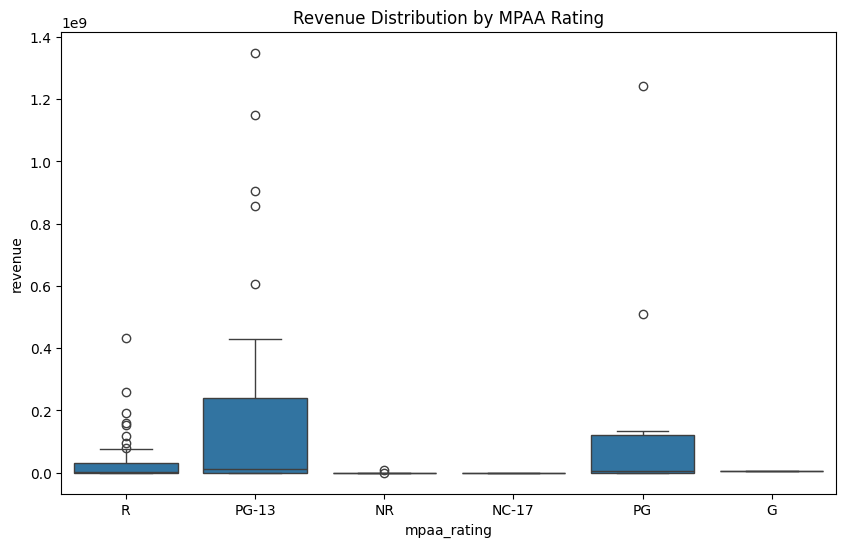

In [31]:
# 1. Perform ANOVA test
sql_anova = text("""
    SELECT mpaa_rating, revenue
    FROM tmdb_data
    WHERE revenue IS NOT NULL
""")
df_anova = pd.read_sql(sql_anova, engine)

print(df_anova)

df_anova = pd.read_sql(sql_anova, engine)

# Group data by MPAA rating
groups = [group['revenue'].values for name, group in df_anova.groupby('mpaa_rating')]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*groups)

# 1.2 Reporting Significance
print(f"1.2.1 P-value: {p_value:.5f}")


# 1.2.2 Which Rating Earns the Most Revenue
average_revenue_by_rating = df_anova.groupby('mpaa_rating')['revenue'].mean()
max_revenue_rating = average_revenue_by_rating.idxmax()
print(f"1.2.2 Rating with the highest revenue: {max_revenue_rating}")

# 1.3 Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='mpaa_rating', y='revenue', data=df_anova)
plt.title('Revenue Distribution by MPAA Rating')
plt.show()

2.1 P-value for movie length hypothesis: 0.65044


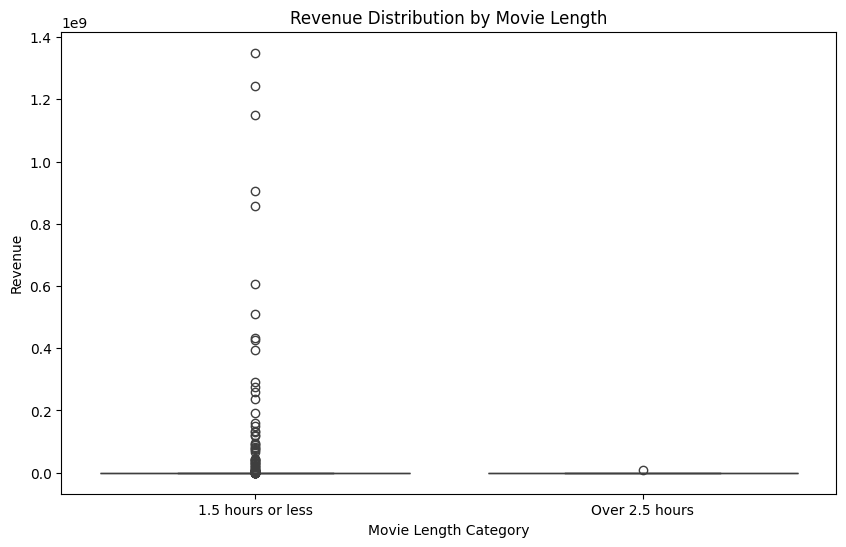

2.2 P-value for release year hypothesis: 0.65720


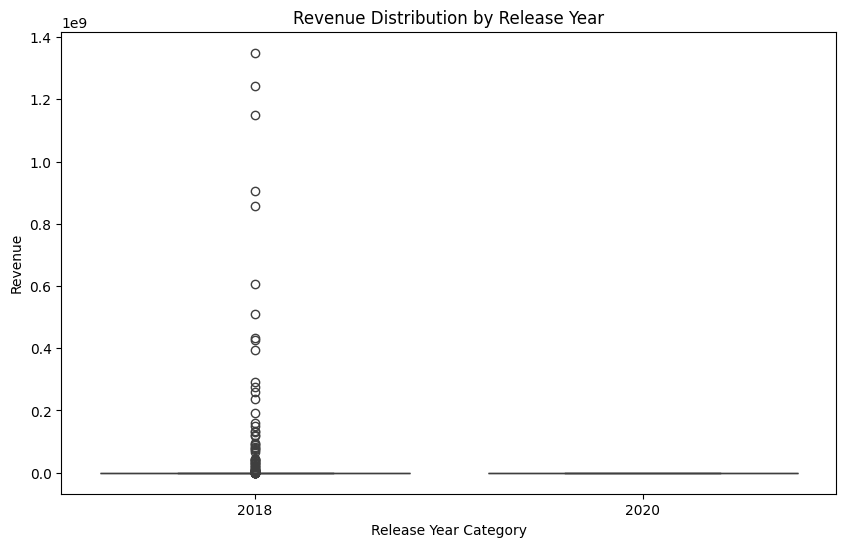

2.2.1 Crosstab for movie ratings by year:
 mpaa_rating  G  NC-17  NR  PG  PG-13   R
start_year                              
2018         1      6  20  13     36  51


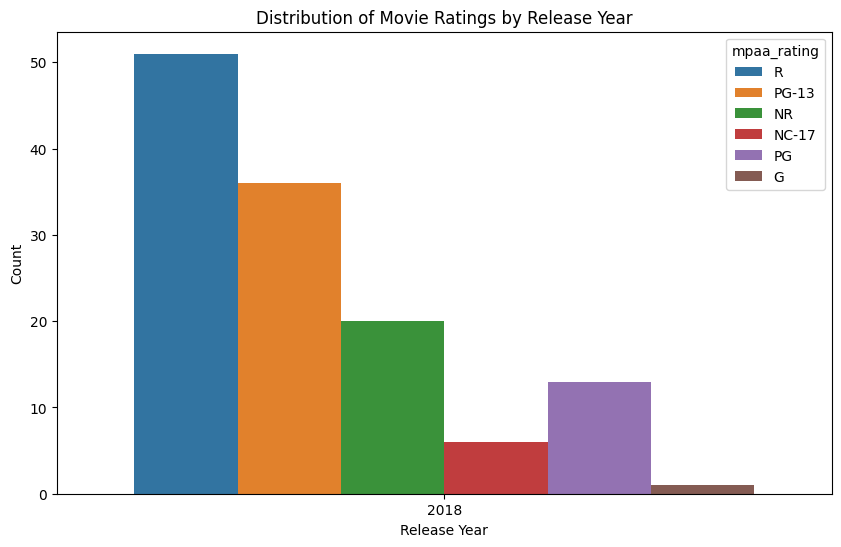

In [39]:

# 2.1 Hypothesis: Do longer movies earn more revenue?
sql_length_hypothesis = text("""
    SELECT CASE WHEN runtime_minutes > 150 THEN 'Over 2.5 hours' ELSE '1.5 hours or less' END AS length_category,
           revenue
    FROM title_basics tb
    JOIN tmdb_data tm ON tb.tconst = tm.tconst
    WHERE revenue IS NOT NULL AND runtime_minutes IS NOT NULL
""")
df_length_hypothesis = pd.read_sql(sql_length_hypothesis, engine)

# Group data by movie length
groups_length = [group['revenue'].values for name, group in df_length_hypothesis.groupby('length_category')]

# Perform t-test for independent samples
t_statistic, p_value_length = f_oneway(*groups_length)
print(f"2.1 P-value for movie length hypothesis: {p_value_length:.5f}")

# Visualization for Hypothesis 2.1
plt.figure(figsize=(10, 6))
sns.boxplot(x='length_category', y='revenue', data=df_length_hypothesis)
plt.title('Revenue Distribution by Movie Length')
plt.xlabel('Movie Length Category')
plt.ylabel('Revenue')
plt.show()

# 2.2 Hypothesis: Does the release year impact revenue?
sql_year_hypothesis = text("""
    SELECT CASE WHEN start_year = 2020 THEN '2020' ELSE '2018' END AS year_category,
           revenue
    FROM title_basics tb
    JOIN tmdb_data tm ON tb.tconst = tm.tconst
    WHERE revenue IS NOT NULL AND start_year IN (2018, 2020)
""")
df_year_hypothesis = pd.read_sql(sql_year_hypothesis, engine)

# Group data by release year
groups_year = [group['revenue'].values for name, group in df_year_hypothesis.groupby('year_category')]

# Perform t-test for independent samples
t_statistic_year, p_value_year = f_oneway(*groups_year)
print(f"2.2 P-value for release year hypothesis: {p_value_year:.5f}")

# Visualization for Hypothesis 2.2
plt.figure(figsize=(10, 6))
sns.boxplot(x='year_category', y='revenue', data=df_year_hypothesis)
plt.title('Revenue Distribution by Release Year')
plt.xlabel('Release Year Category')
plt.ylabel('Revenue')
plt.show()

# 2.2.1 Bonus: How do the years compare for movie ratings?
sql_rating_year_hypothesis = text("""
    SELECT start_year, mpaa_rating
    FROM title_basics tb
    JOIN tmdb_data tm ON tb.tconst = tm.tconst
    WHERE start_year IN (2018, 2020) AND mpaa_rating IS NOT NULL
""")
df_rating_year_hypothesis = pd.read_sql(sql_rating_year_hypothesis, engine)

# Crosstab to compare ratings by year
ct_rating_year = pd.crosstab(df_rating_year_hypothesis['start_year'], df_rating_year_hypothesis['mpaa_rating'])
print("2.2.1 Crosstab for movie ratings by year:\n", ct_rating_year)
# Visualization for Hypothesis 2.2.1
plt.figure(figsize=(10, 6))
sns.countplot(x='start_year', hue='mpaa_rating', data=df_rating_year_hypothesis)
plt.title('Distribution of Movie Ratings by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()